In [1]:
import json
import gzip
from rdkit import Chem
from uuid import uuid4
import numpy as np
from torch.utils.data import Dataset
from typing import Union
import os
import pandas as pd
from pandas import to_datetime

import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import Crippen
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import Fragments

import warnings
from scipy.sparse import SparseEfficiencyWarning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

warnings.simplefilter('ignore',SparseEfficiencyWarning)

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
file_path = '../../datasets/all_ligands-small_run-09Apr24.csv.gz'

json_objects = []
with gzip.open(file_path, 'rt', encoding='utf-8') as file:
    try:
        df = pd.read_csv(file)
    except json.JSONDecodeError as e:
        print(f"Error decoding CSV")
        print(e)

In [7]:
df.shape

(31104, 6)

In [8]:
(~df[df.valid].smiles.isna()).all()

True

In [9]:
df.columns

Index(['anchor_type', 'smiles', 'xyz', 'prompt_atoms', 'valid',
       'model_version'],
      dtype='object')

In [10]:
df[df.valid].shape

(6211, 6)

In [34]:

def generate_features(smiles_list):
  
    descriptor_funcs = {
        'Molecular_Weight': Descriptors.MolWt,
        'LogP': Descriptors.MolLogP,
        'Num_H_Donors': Descriptors.NumHDonors,
        'Num_H_Acceptors': Descriptors.NumHAcceptors,
        'TPSA': rdMolDescriptors.CalcTPSA,
        'Num_Rotatable_Bonds': Lipinski.NumRotatableBonds,
        'Molar_Refractivity': Crippen.MolMR,
        'Heavy_Atom_Count': Descriptors.HeavyAtomCount,
        'NHOH_Count': Descriptors.NHOHCount,
        'NO_Count': Descriptors.NOCount,
        'Num_Alipathic_Rings': Descriptors.NumAliphaticRings,
        'Num_Aromatic_Rings': Descriptors.NumAromaticRings,
        'Num_Saturated_Rings': Descriptors.NumSaturatedRings,
        'Num_Heteroatoms': Descriptors.NumHeteroatoms,
        'Balaban_J': GraphDescriptors.BalabanJ,
        'LabuteASA': rdMolDescriptors.CalcLabuteASA,
        'Chi0v': GraphDescriptors.Chi0v,
        'Chi1v': GraphDescriptors.Chi1v,
        'HallKierAlpha': Descriptors.HallKierAlpha,
        'Kappa1': Descriptors.Kappa1,
        'Num_Valence_Electrons': Descriptors.NumValenceElectrons,
        'Num_Aromatic_Heterocycles': Descriptors.NumAromaticHeterocycles,
        'Num_Aromatic_Carbocycles': Descriptors.NumAromaticCarbocycles,
        'Num_SpiroAtoms': rdMolDescriptors.CalcNumSpiroAtoms,
        'Num_Bridgehead_Atoms': rdMolDescriptors.CalcNumBridgeheadAtoms,

        'clogp': Crippen.MolLogP,
        'mr': Crippen.MolMR,
        'Chi0n': rdMolDescriptors.CalcChi0n,
        'Chi1n': rdMolDescriptors.CalcChi1n,
        'Chi2n': rdMolDescriptors.CalcChi2n,
        'Chi3n': rdMolDescriptors.CalcChi3n,
        'Chi4n': rdMolDescriptors.CalcChi4n,
        'Chi0v': rdMolDescriptors.CalcChi0v,
        'Chi1v': rdMolDescriptors.CalcChi1v,
        'Chi2v': rdMolDescriptors.CalcChi2v,
        'Chi3v': rdMolDescriptors.CalcChi3v,
        'Chi4v': rdMolDescriptors.CalcChi4v,
        'fracsp3': rdMolDescriptors.CalcFractionCSP3,
        'Hall_Kier_Alpha': rdMolDescriptors.CalcHallKierAlpha,
        'Kappa1': rdMolDescriptors.CalcKappa1,
        'Kappa2': rdMolDescriptors.CalcKappa2,
        'Kappa3': rdMolDescriptors.CalcKappa3,
        'LabuteASA': rdMolDescriptors.CalcLabuteASA,
        'Number_Aliphatic_Rings': rdMolDescriptors.CalcNumAliphaticRings,
        'Number_Aromatic_Rings': rdMolDescriptors.CalcNumAromaticRings,
        'Number_Amide_Bonds': rdMolDescriptors.CalcNumAmideBonds,
        'Number_Atom_Stereocenters': rdMolDescriptors.CalcNumAtomStereoCenters,
        'Number_BridgeHead_Atoms': rdMolDescriptors.CalcNumBridgeheadAtoms,
        'Number_HBA': rdMolDescriptors.CalcNumHBA,
        'Number_HBD': rdMolDescriptors.CalcNumHBD,
        'Number_Hetero_Atoms': rdMolDescriptors.CalcNumHeteroatoms,
        'Number_Hetero_Cycles': rdMolDescriptors.CalcNumHeterocycles,
        'Number_Rings': rdMolDescriptors.CalcNumRings,
        'Number_Rotatable_Bonds':rdMolDescriptors.CalcNumRotatableBonds,
        'Number_Spiro': rdMolDescriptors.CalcNumSpiroAtoms,
        'Number_Saturated_Rings': rdMolDescriptors.CalcNumSaturatedRings,
        'Number_Heavy_Atoms': Lipinski.HeavyAtomCount,
        'Number_NH_OH': Lipinski.NHOHCount,
        'Number_N_O': Lipinski.NOCount,
        'Number_Valence_Electrons': Descriptors.NumValenceElectrons,
        'Max_Partial_Charge': Descriptors.MaxPartialCharge,
        'Min_Partial_Charge': Descriptors.MinPartialCharge,
    }
    
    features_df = pd.DataFrame(columns=descriptor_funcs.keys())    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            row = {}
            row['smiles_string'] = smiles
            for desc_name, desc_func in descriptor_funcs.items():
                row[desc_name] = float('nan')
            features_df = features_df.append(pd.Series(row, index=descriptor_funcs.keys()), ignore_index=True)
        else:
            row = {}
            row['smiles_string'] = smiles
            for desc_name, desc_func in descriptor_funcs.items():
                try:
                    row[desc_name] = desc_func(mol)
                except Exception as e:
                    print(f"Error calculating {desc_name} for SMILES {smiles}: {str(e)}")
                    row[desc_name] = float('nan')
            features_df = pd.concat([features_df, pd.DataFrame([row])], ignore_index=True)
    
    return features_df

In [35]:
list_of_smiles = df[df.valid].smiles.tolist()

In [36]:
len(list_of_smiles)

6211

In [92]:
features = generate_features(list_of_smiles)

[11:38:17] Conflicting single bond directions around double bond at index 6.
[11:38:17]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:38:18] Conflicting single bond directions around double bond at index 10.
[11:38:18]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:38:18] Conflicting single bond directions around double bond at index 20.
[11:38:18]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:38:19] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[11:38:24] Conflicting single bond directions around double bond at index 5.
[11:38:24]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:38:27] Conflicting single bond directions around double bond at index 18.
[11:38:27]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [93]:
features.head()

,Molecular_Weight,LogP,Num_H_Donors,Num_H_Acceptors,TPSA,Num_Rotatable_Bonds,Molar_Refractivity,Heavy_Atom_Count,NHOH_Count,NO_Count,Num_Alipathic_Rings,Num_Aromatic_Rings,Num_Saturated_Rings,Num_Heteroatoms,Balaban_J,LabuteASA,Chi0v,Chi1v,HallKierAlpha,Kappa1,Num_Valence_Electrons,Num_Aromatic_Heterocycles,Num_Aromatic_Carbocycles,Num_SpiroAtoms,Num_Bridgehead_Atoms,clogp,mr,Chi0n,Chi1n,Chi2n,Chi3n,Chi4n,Chi2v,Chi3v,Chi4v,fracsp3,Hall_Kier_Alpha,Kappa2,Kappa3,Number_Aliphatic_Rings,Number_Aromatic_Rings,Number_Amide_Bonds,Number_Atom_Stereocenters,Number_BridgeHead_Atoms,Number_HBA,Number_HBD,Number_Hetero_Atoms,Number_Hetero_Cycles,Number_Rings,Number_Rotatable_Bonds,Number_Spiro,Number_Saturated_Rings,Number_Heavy_Atoms,Number_NH_OH,Number_N_O,Number_Valence_Electrons,Max_Partial_Charge,Min_Partial_Charge,smiles_string
0,406.380,4.87294,0,7,126.05,5,111.9850,31,0,7,0,3,0,8,1.995683,176.198618,15.820347,8.785196,-5.00,20.727041,146,1,2,0,0,4.87294,111.9850,15.820347,8.785196,6.152787,4.134085,2.649921,6.152787,4.134085,2.649921,0.0,-5.00,9.467456,5.084583,0,3,0,0,0,7,0,8,1,3,5,0,0,31,0,7,146,0.214953,-0.217242,N#C/C(=N\c1cc(/C=C(\N=O)c2ccc(C#N)cc2)cc(F)n1)...
1,405.373,2.96616,0,8,129.62,3,108.9855,31,0,8,2,2,0,8,1.660646,175.536171,15.811666,8.984823,-4.95,19.370058,146,0,2,0,0,2.96616,108.9855,15.811666,8.984823,6.379276,4.424758,2.813346,6.379276,4.424758,2.813346,0.0,-4.95,8.194187,3.949527,2,2,0,0,0,8,0,8,2,4,3,0,0,31,0,8,146,0.344407,-0.402191,N#Cc1ccc(C(=O)Oc2ccc3cnc(-c4ccc(C#N)cc4)c(=O)c...
2,407.385,4.44716,1,7,119.53,6,109.6773,31,1,7,1,3,0,7,1.522292,176.902803,15.941802,9.088607,-4.88,19.437021,148,1,2,0,0,4.44716,109.6773,15.941802,9.088607,6.451245,4.490267,2.825906,6.451245,4.490267,2.825906,0.0,-4.88,8.237540,4.115465,1,3,0,0,0,7,1,7,2,4,6,0,0,31,1,7,148,0.336080,-0.511547,N#Cc1ccc(C2=C(O/C(=C\O)C(=O)c3ccnc(-c4ccc(C#N)...
3,402.417,3.59117,0,3,90.89,2,119.1959,31,0,7,3,2,0,7,1.459793,177.856833,16.226840,9.406372,-4.63,18.401850,146,0,2,1,0,3.59117,119.1959,16.226840,9.406372,7.162617,5.240729,3.614721,7.162617,5.240729,3.614721,0.0,-4.63,6.714671,2.964195,3,2,1,1,0,3,0,7,2,5,2,1,0,31,0,7,146,0.314412,-0.762793,[CH2-][N+]1=C[N@@+]2(N=C2c2ccc(C#N)cc2)c2cc(C(...
4,405.373,2.44646,0,6,144.69,5,110.7435,31,0,8,1,2,0,8,1.848502,176.425153,15.864072,8.724865,-4.88,20.844036,146,0,2,0,0,2.44646,110.7435,15.864072,8.724865,6.135546,4.119936,2.508959,6.135546,4.119936,2.508959,0.0,-4.88,9.079301,4.758600,1,2,1,0,0,6,0,8,1,3,5,0,0,31,0,8,146,NaN,NaN,C=C(C1=NC(=O)C(/C([O-])=N/c2ccc(C#N)cc2)=C1)/C...


In [94]:
essential_plot_cols = [col for col in features.columns if col not in ['smiles_string', 'creation_time']]

In [95]:
def remove_correlated_features(df, essential_cols=None, threshold=0.99):
    """
    Removes highly correlated features from a DataFrame, keeping the first of the correlated columns.
    
    Parameters:
    - df: pandas.DataFrame
    - threshold: float, features are removed if their correlations are above this value
    
    Returns:
    - df: pandas.DataFrame, with highly correlated features removed
    """
    ignored_cols = [col for col in df.columns if col not in essential_cols] 
    ignored_df = df[ignored_cols]
    df = df[essential_cols]
    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # List to hold pairs of correlated columns
    correlated_pairs = []

    # Find index of feature columns with correlation greater than the threshold
    to_drop = set()
    for row in range(len(upper_tri)):
        for col in range(row + 1, len(upper_tri.columns)):
            if upper_tri.iat[row, col] > threshold:  # check if correlation exceeds threshold
                col_name = upper_tri.columns[col]
                row_name = upper_tri.columns[row]
                correlated_pairs.append((row_name, col_name))
                to_drop.add(col_name)  # add the later column name in the pair

    # Print correlated pairs
    print("Correlated pairs above the threshold:")
    for pair in correlated_pairs:
        print(pair)

    # Drop the features
    df_reduced = df.drop(to_drop, axis=1)
    df_reduced = pd.concat([df_reduced, ignored_df], axis=1)
    
    return df_reduced

In [96]:
features.head()

,Molecular_Weight,LogP,Num_H_Donors,Num_H_Acceptors,TPSA,Num_Rotatable_Bonds,Molar_Refractivity,Heavy_Atom_Count,NHOH_Count,NO_Count,Num_Alipathic_Rings,Num_Aromatic_Rings,Num_Saturated_Rings,Num_Heteroatoms,Balaban_J,LabuteASA,Chi0v,Chi1v,HallKierAlpha,Kappa1,Num_Valence_Electrons,Num_Aromatic_Heterocycles,Num_Aromatic_Carbocycles,Num_SpiroAtoms,Num_Bridgehead_Atoms,clogp,mr,Chi0n,Chi1n,Chi2n,Chi3n,Chi4n,Chi2v,Chi3v,Chi4v,fracsp3,Hall_Kier_Alpha,Kappa2,Kappa3,Number_Aliphatic_Rings,Number_Aromatic_Rings,Number_Amide_Bonds,Number_Atom_Stereocenters,Number_BridgeHead_Atoms,Number_HBA,Number_HBD,Number_Hetero_Atoms,Number_Hetero_Cycles,Number_Rings,Number_Rotatable_Bonds,Number_Spiro,Number_Saturated_Rings,Number_Heavy_Atoms,Number_NH_OH,Number_N_O,Number_Valence_Electrons,Max_Partial_Charge,Min_Partial_Charge,smiles_string
0,406.380,4.87294,0,7,126.05,5,111.9850,31,0,7,0,3,0,8,1.995683,176.198618,15.820347,8.785196,-5.00,20.727041,146,1,2,0,0,4.87294,111.9850,15.820347,8.785196,6.152787,4.134085,2.649921,6.152787,4.134085,2.649921,0.0,-5.00,9.467456,5.084583,0,3,0,0,0,7,0,8,1,3,5,0,0,31,0,7,146,0.214953,-0.217242,N#C/C(=N\c1cc(/C=C(\N=O)c2ccc(C#N)cc2)cc(F)n1)...
1,405.373,2.96616,0,8,129.62,3,108.9855,31,0,8,2,2,0,8,1.660646,175.536171,15.811666,8.984823,-4.95,19.370058,146,0,2,0,0,2.96616,108.9855,15.811666,8.984823,6.379276,4.424758,2.813346,6.379276,4.424758,2.813346,0.0,-4.95,8.194187,3.949527,2,2,0,0,0,8,0,8,2,4,3,0,0,31,0,8,146,0.344407,-0.402191,N#Cc1ccc(C(=O)Oc2ccc3cnc(-c4ccc(C#N)cc4)c(=O)c...
2,407.385,4.44716,1,7,119.53,6,109.6773,31,1,7,1,3,0,7,1.522292,176.902803,15.941802,9.088607,-4.88,19.437021,148,1,2,0,0,4.44716,109.6773,15.941802,9.088607,6.451245,4.490267,2.825906,6.451245,4.490267,2.825906,0.0,-4.88,8.237540,4.115465,1,3,0,0,0,7,1,7,2,4,6,0,0,31,1,7,148,0.336080,-0.511547,N#Cc1ccc(C2=C(O/C(=C\O)C(=O)c3ccnc(-c4ccc(C#N)...
3,402.417,3.59117,0,3,90.89,2,119.1959,31,0,7,3,2,0,7,1.459793,177.856833,16.226840,9.406372,-4.63,18.401850,146,0,2,1,0,3.59117,119.1959,16.226840,9.406372,7.162617,5.240729,3.614721,7.162617,5.240729,3.614721,0.0,-4.63,6.714671,2.964195,3,2,1,1,0,3,0,7,2,5,2,1,0,31,0,7,146,0.314412,-0.762793,[CH2-][N+]1=C[N@@+]2(N=C2c2ccc(C#N)cc2)c2cc(C(...
4,405.373,2.44646,0,6,144.69,5,110.7435,31,0,8,1,2,0,8,1.848502,176.425153,15.864072,8.724865,-4.88,20.844036,146,0,2,0,0,2.44646,110.7435,15.864072,8.724865,6.135546,4.119936,2.508959,6.135546,4.119936,2.508959,0.0,-4.88,9.079301,4.758600,1,2,1,0,0,6,0,8,1,3,5,0,0,31,0,8,146,NaN,NaN,C=C(C1=NC(=O)C(/C([O-])=N/c2ccc(C#N)cc2)=C1)/C...


In [97]:
features.shape

(6211, 59)

In [98]:
features = remove_correlated_features(features, essential_cols=essential_plot_cols)

Correlated pairs above the threshold:
('Molecular_Weight', 'Num_Valence_Electrons')
('Molecular_Weight', 'Number_Valence_Electrons')
('LogP', 'clogp')
('Num_H_Donors', 'Number_HBD')
('Num_H_Acceptors', 'Number_HBA')
('Num_Rotatable_Bonds', 'Number_Rotatable_Bonds')
('Molar_Refractivity', 'mr')
('Heavy_Atom_Count', 'LabuteASA')
('Heavy_Atom_Count', 'Num_Valence_Electrons')
('Heavy_Atom_Count', 'Number_Heavy_Atoms')
('Heavy_Atom_Count', 'Number_Valence_Electrons')
('NHOH_Count', 'Number_NH_OH')
('NO_Count', 'Number_N_O')
('Num_Alipathic_Rings', 'Number_Aliphatic_Rings')
('Num_Aromatic_Rings', 'Number_Aromatic_Rings')
('Num_Saturated_Rings', 'Number_Saturated_Rings')
('Num_Heteroatoms', 'Number_Hetero_Atoms')
('LabuteASA', 'Chi0v')
('LabuteASA', 'Number_Heavy_Atoms')
('HallKierAlpha', 'Hall_Kier_Alpha')
('Num_Valence_Electrons', 'Number_Heavy_Atoms')
('Num_Valence_Electrons', 'Number_Valence_Electrons')
('Num_SpiroAtoms', 'Number_Spiro')
('Num_Bridgehead_Atoms', 'Number_BridgeHead_Atoms')

In [99]:
features.head()

,Molecular_Weight,LogP,Num_H_Donors,Num_H_Acceptors,TPSA,Num_Rotatable_Bonds,Molar_Refractivity,Heavy_Atom_Count,NHOH_Count,NO_Count,Num_Alipathic_Rings,Num_Aromatic_Rings,Num_Saturated_Rings,Num_Heteroatoms,Balaban_J,Chi1v,HallKierAlpha,Kappa1,Num_Aromatic_Heterocycles,Num_Aromatic_Carbocycles,Num_SpiroAtoms,Num_Bridgehead_Atoms,Chi0n,Chi1n,Chi2n,Chi2v,fracsp3,Kappa2,Kappa3,Number_Amide_Bonds,Number_Atom_Stereocenters,Number_Hetero_Cycles,Number_Rings,Max_Partial_Charge,Min_Partial_Charge,smiles_string
0,406.380,4.87294,0,7,126.05,5,111.9850,31,0,7,0,3,0,8,1.995683,8.785196,-5.00,20.727041,1,2,0,0,15.820347,8.785196,6.152787,6.152787,0.0,9.467456,5.084583,0,0,1,3,0.214953,-0.217242,N#C/C(=N\c1cc(/C=C(\N=O)c2ccc(C#N)cc2)cc(F)n1)...
1,405.373,2.96616,0,8,129.62,3,108.9855,31,0,8,2,2,0,8,1.660646,8.984823,-4.95,19.370058,0,2,0,0,15.811666,8.984823,6.379276,6.379276,0.0,8.194187,3.949527,0,0,2,4,0.344407,-0.402191,N#Cc1ccc(C(=O)Oc2ccc3cnc(-c4ccc(C#N)cc4)c(=O)c...
2,407.385,4.44716,1,7,119.53,6,109.6773,31,1,7,1,3,0,7,1.522292,9.088607,-4.88,19.437021,1,2,0,0,15.941802,9.088607,6.451245,6.451245,0.0,8.237540,4.115465,0,0,2,4,0.336080,-0.511547,N#Cc1ccc(C2=C(O/C(=C\O)C(=O)c3ccnc(-c4ccc(C#N)...
3,402.417,3.59117,0,3,90.89,2,119.1959,31,0,7,3,2,0,7,1.459793,9.406372,-4.63,18.401850,0,2,1,0,16.226840,9.406372,7.162617,7.162617,0.0,6.714671,2.964195,1,1,2,5,0.314412,-0.762793,[CH2-][N+]1=C[N@@+]2(N=C2c2ccc(C#N)cc2)c2cc(C(...
4,405.373,2.44646,0,6,144.69,5,110.7435,31,0,8,1,2,0,8,1.848502,8.724865,-4.88,20.844036,0,2,0,0,15.864072,8.724865,6.135546,6.135546,0.0,9.079301,4.758600,1,0,1,3,NaN,NaN,C=C(C1=NC(=O)C(/C([O-])=N/c2ccc(C#N)cc2)=C1)/C...


In [100]:
features.shape

(6211, 36)

In [108]:
essential_plot_cols = [col for col in features.columns if col not in ['smiles_string', 'creation_time']]

In [101]:
def plot_isomap_projection(features_df, n_neighbors=20, n_components=2):
    clean_df = features_df.dropna()
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(clean_df)
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    projected_features = isomap.fit_transform(features_scaled)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(projected_features[:, 0], projected_features[:, 1], edgecolor='k', alpha=0.7, s=50)
    plt.title(f'2D Isomap Projection of Molecular Descriptors with {n_neighbors} neighbors')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

    return projected_features

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 6 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)


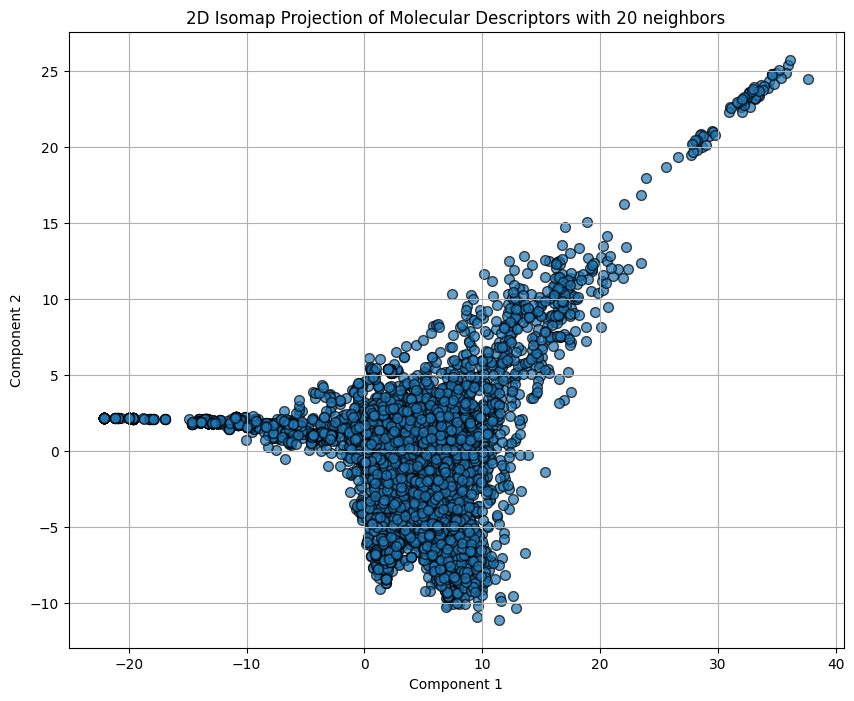

array([[ 3.3251268 , -5.72140824],
       [ 4.59532835, -1.03856862],
       [ 5.69058108, -3.51714681],
       ...,
       [ 4.38185552,  2.78904283],
       [ 9.87204074, -2.06898996],
       [10.00118271, -3.93595714]])

In [109]:
plot_isomap_projection(features[essential_plot_cols])

In [103]:
def plot_pca_projection(features_df, n_components=2):
    # Drop any rows with NaN values to avoid errors with PCA
    clean_df = features_df.dropna()
    
    # Standardizing the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(clean_df)
    
    # Applying PCA
    pca = PCA(n_components=n_components)
    projected_features = pca.fit_transform(features_scaled)
    
    # Creating the plot
    plt.figure(figsize=(10, 8))
    plt.scatter(projected_features[:, 0], projected_features[:, 1], edgecolor='k', alpha=0.7, s=50)
    plt.title('2D PCA Projection of Molecular Descriptors')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

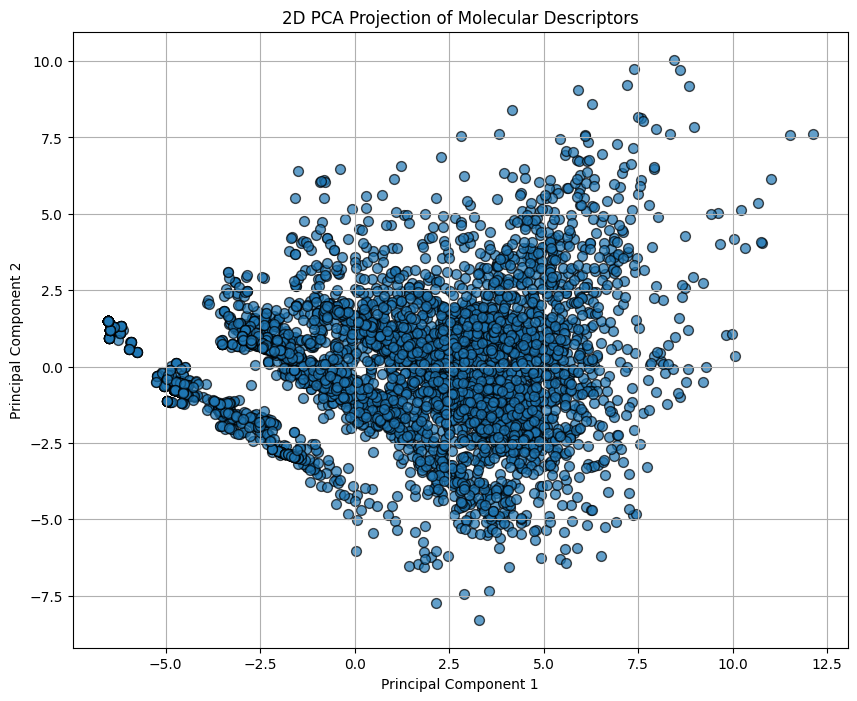

In [110]:
plot_pca_projection(features[essential_plot_cols])

In [111]:
def plot_tsne_projection(features_df, n_components=2, perplexity=30, n_iter=1000):
    # Drop any rows with NaN values to avoid errors with t-SNE
    essential_cols = [col for col in features_df.columns if col not in ['strain', 'smiles_string', 'creation_time']]
    clean_df = features_df.dropna(subset=essential_cols)

    # Standardizing the features (excluding 'strain' which is categorical)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(clean_df[essential_cols])
    
    # Applying t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    projected_features = tsne.fit_transform(features_scaled)
    
    # Creating the plot
    plt.figure(figsize=(10, 8))
    plt.scatter(projected_features[:, 0], projected_features[:, 1], edgecolor='k', alpha=0.5)
    plt.title('2D t-SNE Projection of Molecular Descriptors')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

    return projected_features

In [112]:
def plot_tsne_projection_time_and_strain(features_df, n_components=2, perplexity=30, n_iter=1000):
    # Drop any rows with NaN values to avoid errors with t-SNE
    essential_cols = [col for col in features_df.columns if col not in ['strain', 'smiles_string', 'creation_time']]
    clean_df = features_df.dropna(subset=essential_cols)
    clean_df['creation_time'] = to_datetime(clean_df['creation_time'])

    # Standardizing the features (excluding 'strain' which is categorical)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(clean_df[essential_cols])
    
    # Applying t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    projected_features = tsne.fit_transform(features_scaled)
    
    # Normalize 'strain' values for colormap application
    strain_values = clean_df['strain'].values
    norm = mcolors.Normalize(vmin=np.nanmin(strain_values), vmax=np.nanmax(strain_values), clip=True)
    
    # Create a yellow to red colormap
    yellow_red = mcolors.LinearSegmentedColormap.from_list("", ["yellow", "red"])
    
    # Map 'strain' values to colors, NaNs to blue
    point_colors = [yellow_red(norm(value)) if not np.isnan(value) else [0, 0, 1, 1] for value in strain_values]

    min_date = clean_df['creation_time'].min()
    clean_df['seconds_since_min'] = (clean_df['creation_time'] - min_date).dt.seconds
    
    # Normalize 'days_since_min' for point sizes: scale from 10 to 100
    size_norm = mcolors.Normalize(vmin=clean_df['seconds_since_min'].min(), vmax=clean_df['seconds_since_min'].max())
    point_sizes = [size_norm(value) * 900 + 100 for value in clean_df['seconds_since_min'].values]  # Scale sizes between 100 and 1000
    
    # Creating the plot
    plt.figure(figsize=(10, 8))
    plt.scatter(projected_features[:, 0], projected_features[:, 1], color=point_colors, 
                s=point_sizes, edgecolor='k', alpha=0.5)
    plt.title('2D t-SNE Projection of Molecular Descriptors')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=yellow_red), label='Strain')
    plt.grid(True)
    plt.show()

    return projected_features

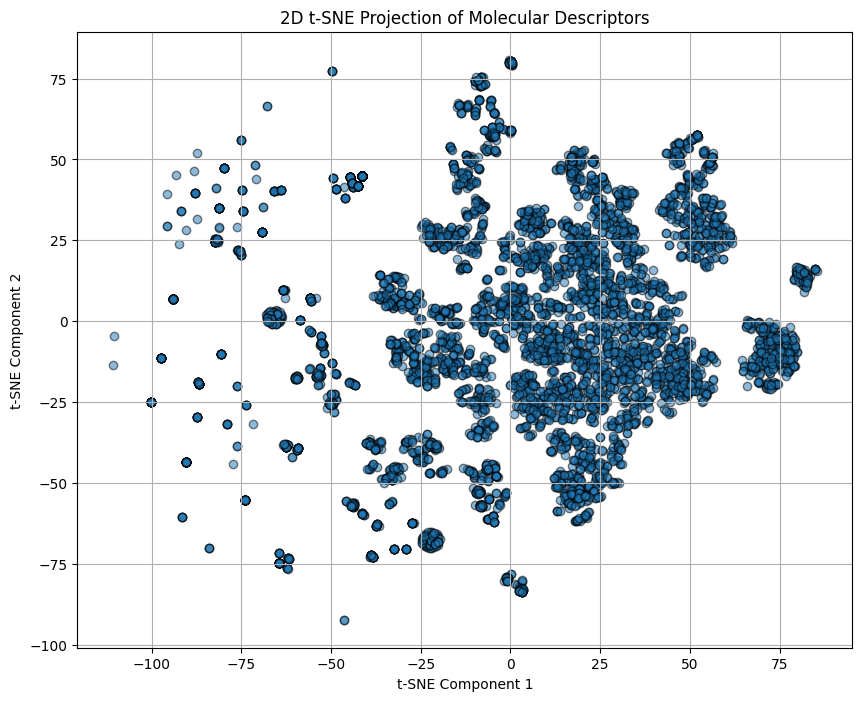

array([[-12.242562 ,  33.137234 ],
       [  4.077076 ,   4.3997297],
       [ 22.235262 ,   8.96836  ],
       ...,
       [ 26.997704 , -48.142803 ],
       [ 44.328304 ,  23.613935 ],
       [ 25.863821 ,  29.840914 ]], dtype=float32)

In [113]:
plot_tsne_projection(features[essential_plot_cols])

In [114]:
file_path = '../../datasets/mofs-small_run-09Apr24.json.gz'

json_objects = []
with gzip.open(file_path, 'rt', encoding='utf-8') as file:
    for line in file:
        try:
            json_object = json.loads(line)
            json_objects.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from line: {line}")
            print(e)

In [115]:
len(json_objects)

98

In [116]:
for json_object in json_objects:
    for ligand in json_object['ligands']:
        if ligand['smiles'] in list(features.smiles_string):
            idx = features[features['smiles_string'] == ligand['smiles']].index
            features.loc[idx, 'strain'] = json_object['structure_stability']['uff']
            features.loc[idx, 'creation_time'] = json_object['times']['created']['$date']
        else:
            print(f"Ligand not found: {ligand['smiles']}")

In [117]:
len(features)

6211

In [118]:
features.head()

,Molecular_Weight,LogP,Num_H_Donors,Num_H_Acceptors,TPSA,Num_Rotatable_Bonds,Molar_Refractivity,Heavy_Atom_Count,NHOH_Count,NO_Count,Num_Alipathic_Rings,Num_Aromatic_Rings,Num_Saturated_Rings,Num_Heteroatoms,Balaban_J,Chi1v,HallKierAlpha,Kappa1,Num_Aromatic_Heterocycles,Num_Aromatic_Carbocycles,Num_SpiroAtoms,Num_Bridgehead_Atoms,Chi0n,Chi1n,Chi2n,Chi2v,fracsp3,Kappa2,Kappa3,Number_Amide_Bonds,Number_Atom_Stereocenters,Number_Hetero_Cycles,Number_Rings,Max_Partial_Charge,Min_Partial_Charge,smiles_string,strain,creation_time
0,406.380,4.87294,0,7,126.05,5,111.9850,31,0,7,0,3,0,8,1.995683,8.785196,-5.00,20.727041,1,2,0,0,15.820347,8.785196,6.152787,6.152787,0.0,9.467456,5.084583,0,0,1,3,0.214953,-0.217242,N#C/C(=N\c1cc(/C=C(\N=O)c2ccc(C#N)cc2)cc(F)n1)...,NaN,NaN
1,405.373,2.96616,0,8,129.62,3,108.9855,31,0,8,2,2,0,8,1.660646,8.984823,-4.95,19.370058,0,2,0,0,15.811666,8.984823,6.379276,6.379276,0.0,8.194187,3.949527,0,0,2,4,0.344407,-0.402191,N#Cc1ccc(C(=O)Oc2ccc3cnc(-c4ccc(C#N)cc4)c(=O)c...,NaN,NaN
2,407.385,4.44716,1,7,119.53,6,109.6773,31,1,7,1,3,0,7,1.522292,9.088607,-4.88,19.437021,1,2,0,0,15.941802,9.088607,6.451245,6.451245,0.0,8.237540,4.115465,0,0,2,4,0.336080,-0.511547,N#Cc1ccc(C2=C(O/C(=C\O)C(=O)c3ccnc(-c4ccc(C#N)...,NaN,NaN
3,402.417,3.59117,0,3,90.89,2,119.1959,31,0,7,3,2,0,7,1.459793,9.406372,-4.63,18.401850,0,2,1,0,16.226840,9.406372,7.162617,7.162617,0.0,6.714671,2.964195,1,1,2,5,0.314412,-0.762793,[CH2-][N+]1=C[N@@+]2(N=C2c2ccc(C#N)cc2)c2cc(C(...,NaN,NaN
4,405.373,2.44646,0,6,144.69,5,110.7435,31,0,8,1,2,0,8,1.848502,8.724865,-4.88,20.844036,0,2,0,0,15.864072,8.724865,6.135546,6.135546,0.0,9.079301,4.758600,1,0,1,3,NaN,NaN,C=C(C1=NC(=O)C(/C([O-])=N/c2ccc(C#N)cc2)=C1)/C...,NaN,NaN


In [119]:
sum(features.strain.isna())

5347

In [120]:
6211 - 5347

864

/var/folders/pb/vktf3d2x011442j3m334qsn80000gn/T/ipykernel_88109/1455710414.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['creation_time'] = to_datetime(clean_df['creation_time'])
/var/folders/pb/vktf3d2x011442j3m334qsn80000gn/T/ipykernel_88109/1455710414.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['seconds_since_min'] = (clean_df['creation_time'] - min_date).dt.seconds
/var/folders/pb/vktf3d2x011442j3m334qsn80000gn/T/ipykernel_88109/1455710414.py:39: MatplotlibDeprecationWa

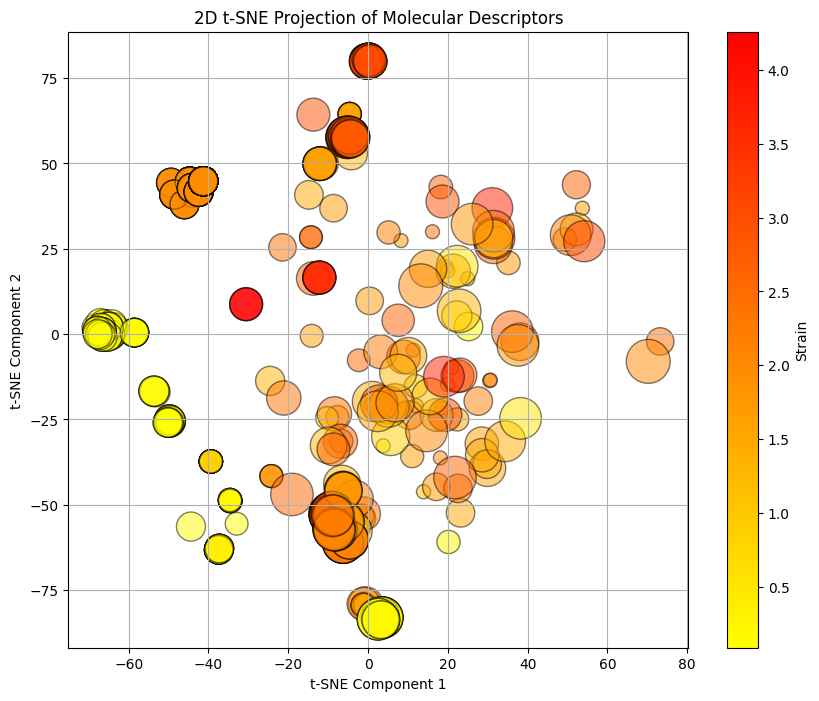

array([[-12.242562 ,  33.137234 ],
       [  4.077076 ,   4.3997297],
       [ 22.235262 ,   8.96836  ],
       ...,
       [ 26.997704 , -48.142803 ],
       [ 44.328304 ,  23.613935 ],
       [ 25.863821 ,  29.840914 ]], dtype=float32)

In [121]:
plot_tsne_projection_time_and_strain(features)